In [80]:
import json
import numpy as np

# 参数
rounds = 7
num_blocks = 12
block_size = 16
max_vars = rounds * num_blocks * block_size  # 7*12*16=1344

# 读取 JSON
with open('checkpoint_7-2-4(2).json', 'r') as f:
    solution_data = json.load(f)

# 初始化三维数组
solution_array = [[[0 for _ in range(block_size)] for _ in range(num_blocks)] for _ in range(rounds)]

count = 0
for key, val in solution_data.items():
    if count >= max_vars:
        break  # 只取前 7*12*16 个元素
    parts = key.split('_')  # 假设 key 格式是 x_r_b_j
    r, b, j = int(parts[1]), int(parts[2]), int(parts[3])
    if r < rounds and b < num_blocks and j < block_size:
        solution_array[r][b][j] = int(round(val))
        count += 1

S= solution_array
# S = [[] for _ in range(rounds)]
# for i in range(rounds):
#     for j in range(num_blocks):
#         S[i].append((solution_array[i][j]))
# print(len(S))
S = [state for state in S for _ in range(2)]

In [82]:
class ActiveGroups:
    def __init__(self, S, rounds, num_blocks=12, block_size=16):
        """
        S: 截断差分路径 (rounds  num_blocks  block_size)
        rounds: 轮数
        num_blocks: 每轮的block数 (默认12)
        block_size: 每个block的字节数 (默认16)
        """
        self.S = S
        self.rounds = rounds*2 #####################SB两岸增加了一个state
        self.num_blocks = num_blocks
        self.block_size = block_size

        # group_id[r][b][byte] = 属于哪个组编号
        self.group_id = [[[None for _ in range(block_size)] 
                          for _ in range(num_blocks)] 
                         for _ in range(rounds*2)]
        
        self.current_group = 0   # 下一个可用组编号

    def new_group(self):
        """新建一个组编号"""
        self.current_group += 1
        g = self.current_group
        return g

    def assign_group(self, r, b, byte, group):
        """为某个字节赋组编号"""
        self.group_id[r][b][byte] = group

    def propagate_linear(self, r, b, byte, r_next, b_next, byte_next):
        """线性传播 (SR, MC, XOR 0)"""
        g = self.group_id[r][b][byte]
        if g is None:  # 如果当前还没分组#################这个if是否可以删掉
            g = self.new_group()
            self.assign_group(r, b, byte, g)
        self.assign_group(r_next, b_next, byte_next, g)

    def propagate_sb(self, r, b, byte, r_next, b_next, byte_next):
        """S-box 传播 (必须新起一组)"""
        g_new = self.new_group()
        self.assign_group(r_next, b_next, byte_next, g_new)

    # def propagate_xor(self, r, b, bytes_in, r_next, b_next, byte_next):
    #     """XOR 传播 (多个输入 → 新起一组)"""
    #     if self.S[r][b][bytes_in] == 1:
    #         g_new = self.new_group()
    #         self.assign_group(r_next, b_next, byte_next, g_new)

    def get_groups(self):
        return self.group_id

    def sb_block(self, r, b, r_next, b_next):##################经过SB后整个块同一成一类

        for byte in range(self.block_size):
            byte_next = byte
            if self.S[r][b][byte] == 1:
                self.propagate_sb(r, b, byte, r_next, b_next, byte_next)#########先找到第一个1，定义一个新类
                g = self.current_group
                break
        if any(self.S[r][b][byte] == 1 for byte in range(self.block_size)):
            for byte_rest in range(byte+1, self.block_size):
                byte_next = byte_rest
                if self.S[r][b][byte_rest] == 1:
                    self.assign_group(r_next, b_next, byte_next, g)#####后面都用g的族类
    
    def sb_block_non(self, r, b, r_next, b_next):
        for byte in range(self.block_size):
            byte_next = byte
            if self.S[r][b][byte] == 1:
                self.propagate_linear(r, b, byte, r_next, b_next, byte_next)

    def srmcak_block(self, r1, b1, r2,  b2, r_next, b_next):
        for byte_next in range(self.block_size):########注意这里没有考虑mc之后为0+后面一个1输出一个1，实在不知道怎么建模
            if self.S[r_next][b_next][byte_next] == 1:
                if self.S[r2][b2][byte_next] == 1:#############块2的字节索引和输出一样
                    self. propagate_sb(r2, b2, byte_next, r_next, b_next, byte_next)
                else:###################那就说明这里的活跃1是MC带来的
                    
                    # # 检查 r1,b1 是否有活跃字节
                    # active_bytes_r1 = [i for i,v in enumerate(self.S[r1][b1]) if v==1]
                    # if not active_bytes_r1:
                    #     continue   # 如果 r1,b1 全0，就跳过

                    byte = self.S[r1][b1].index(1)#################不可能没有1，否则的话还输出1，只能说明是块2带来的
                    g = self.group_id[r1][b1][byte]#########刚过SB都是一个组
                    self.assign_group(r_next, b_next, byte_next, g)

    def xor_block(self, r1, b1, r2,  b2, r_next, b_next):
        for byte_next in range(self.block_size):
            if self.S[r_next][b_next][byte_next] == 1:
                if self.S[r1][b1][byte_next] == 1 and self.S[r2][b2][byte_next] == 1:
                    self. propagate_sb(r1, b1, byte_next, r_next, b_next, byte_next)
                elif self.S[r1][b1][byte_next] == 1:
                    self.propagate_linear(r1, b1, byte_next, r_next, b_next, byte_next)
                elif self.S[r2][b2][byte_next] == 1:
                    self.propagate_linear(r2, b2, byte_next, r_next, b_next, byte_next)

    def first_group(self):
        for b in range(self.num_blocks):
            for byte in range(self.block_size):
                # print(self.S[0][b][byte])
                if self.S[0][b][byte] == 1:
                    group = self.new_group()
                    self.assign_group(0, b, byte, group)
                    # print(f"First layer: assigned group {group} to block {b}, byte {byte}")


    def Permutation(self, r, r_mid, r_next):
        self.sb_block(r, 2, r_mid, 2)
        self.sb_block(r, 3, r_mid, 3)
        self.sb_block(r, 1, r_mid, 1)
        self.sb_block(r, 6, r_mid, 6)
        self.sb_block(r, 0, r_mid, 0)
        self.sb_block(r, 7, r_mid, 7)
        self.sb_block_non(r, 4, r_mid, 4)
        self.sb_block_non(r, 5, r_mid, 5)
        self.sb_block_non(r, 8, r_mid, 8)
        self.sb_block_non(r, 9, r_mid, 9)
        self.sb_block_non(r, 10, r_mid, 10)
        self.sb_block_non(r, 11, r_mid, 11)

        self.srmcak_block(r_mid, 2, r_mid, 8, r_next, 0)###############8没有参与sb，所以这里包括后面都用r_mid
        self.srmcak_block(r_mid, 3, r_mid, 10, r_next, 2)
        self.srmcak_block(r_mid, 1, r_mid, 4, r_next, 3)
        self.srmcak_block(r_mid, 6, r_mid, 4, r_next, 8)
        self.srmcak_block(r_mid, 7, r_mid, 9, r_next, 10)
        self.sb_block_non(r_mid, 0, r_next, 9) #####因为0到9之间过一个aes，没有经过异或，所以直接用sb_non把类型平移到下面

        self.xor_block(r, 0, r, 9, r_next, 1) #########都用的r的状态，因为r_mid可能已经过了aes
        self.xor_block(r, 6, r, 11, r_next, 4)
        self.xor_block(r, 7, r, 8, r_next, 5)
        self.xor_block(r, 2, r, 3, r_next, 6)
        self.xor_block(r, 1, r, 5, r_next, 7)
        self.xor_block(r, 5, r, 10, r_next, 11)

    def P_rounds(self, rounds):
        rounds = (rounds - 1) * 2
        self.first_group()
        for i in range(0, rounds, 2):#############最后一个13层没有意义
            self.Permutation(i, i+1, i+2)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_groups(group_id, show_numbers=True):
#     rounds = len(group_id)
#     num_blocks = len(group_id[0])
#     block_size = len(group_id[0][0])
    
#     fig, axes = plt.subplots(rounds, num_blocks, figsize=(2*num_blocks, 2*rounds))
    
#     if rounds == 1:
#         axes = np.array([axes])
#     if num_blocks == 1:
#         axes = axes.reshape(rounds, 1)
    
#     cmap = plt.colormaps["tab20"]  # Matplotlib >=3.7
#     max_group = max([max([max([0 if v is None else v for v in byte]) for byte in block]) for block in group_id])
    
#     for r in range(rounds):
#         for b in range(num_blocks):
#             ax = axes[r, b]
#             data = np.array(group_id[r][b]).reshape(4,4)
#             data_masked = np.array([[-1 if v is None else v for v in row] for row in data])
#             ax.imshow(data_masked, cmap=cmap, vmin=-1, vmax=max_group)
            
#             if show_numbers:
#                 for i in range(4):
#                     for j in range(4):
#                         if data[i,j] is not None:
#                             ax.text(j, i, str(data[i,j]), ha="center", va="center", fontsize=8, color='black')
            
#             ax.set_xticks([])
#             ax.set_yticks([])
#             ax.set_title(f"R{r}-B{b}", fontsize=6)
    
#     plt.tight_layout()
#     plt.show()


In [85]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

def plot_groups(group_id, show_numbers=True):
    rounds = len(group_id)
    num_blocks = len(group_id[0])
    block_size = len(group_id[0][0])
    
    fig, axes = plt.subplots(rounds, num_blocks, figsize=(2*num_blocks, 2*rounds))
    
    if rounds == 1:
        axes = np.array([axes])
    if num_blocks == 1:
        axes = axes.reshape(rounds, 1)
    
    # 选择一个好看的调色板，比如 tab20
    base_cmap = plt.cm.get_cmap("tab20")  
    # 把第一个颜色固定为白色，其余颜色沿用 tab20
    colors = [(1, 1, 1, 1)] + [base_cmap(i) for i in range(base_cmap.N)]
    cmap = ListedColormap(colors)
    
    max_group = max([max([max([0 if v is None else v for v in byte]) for byte in block]) for block in group_id])
    
    for r in range(rounds):
        for b in range(num_blocks):
            ax = axes[r, b]
            data = np.array(group_id[r][b]).reshape(4,4).T
            # None -> 0，对应白色
            data_masked = np.array([[0 if v is None else v for v in row] for row in data])
            ax.imshow(data_masked, cmap=cmap, vmin=0, vmax=max_group)
            
            if show_numbers:
                for i in range(4):
                    for j in range(4):
                        if data[i,j] is not None:
                            ax.text(j, i, str(data[i,j]), ha="center", va="center", fontsize=8, color='black')
            
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"R{r}-B{b}", fontsize=6)
    
    plt.tight_layout()
    plt.show()


C:\Users\dell\AppData\Local\Temp\ipykernel_4104\1141877743.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap("tab20")


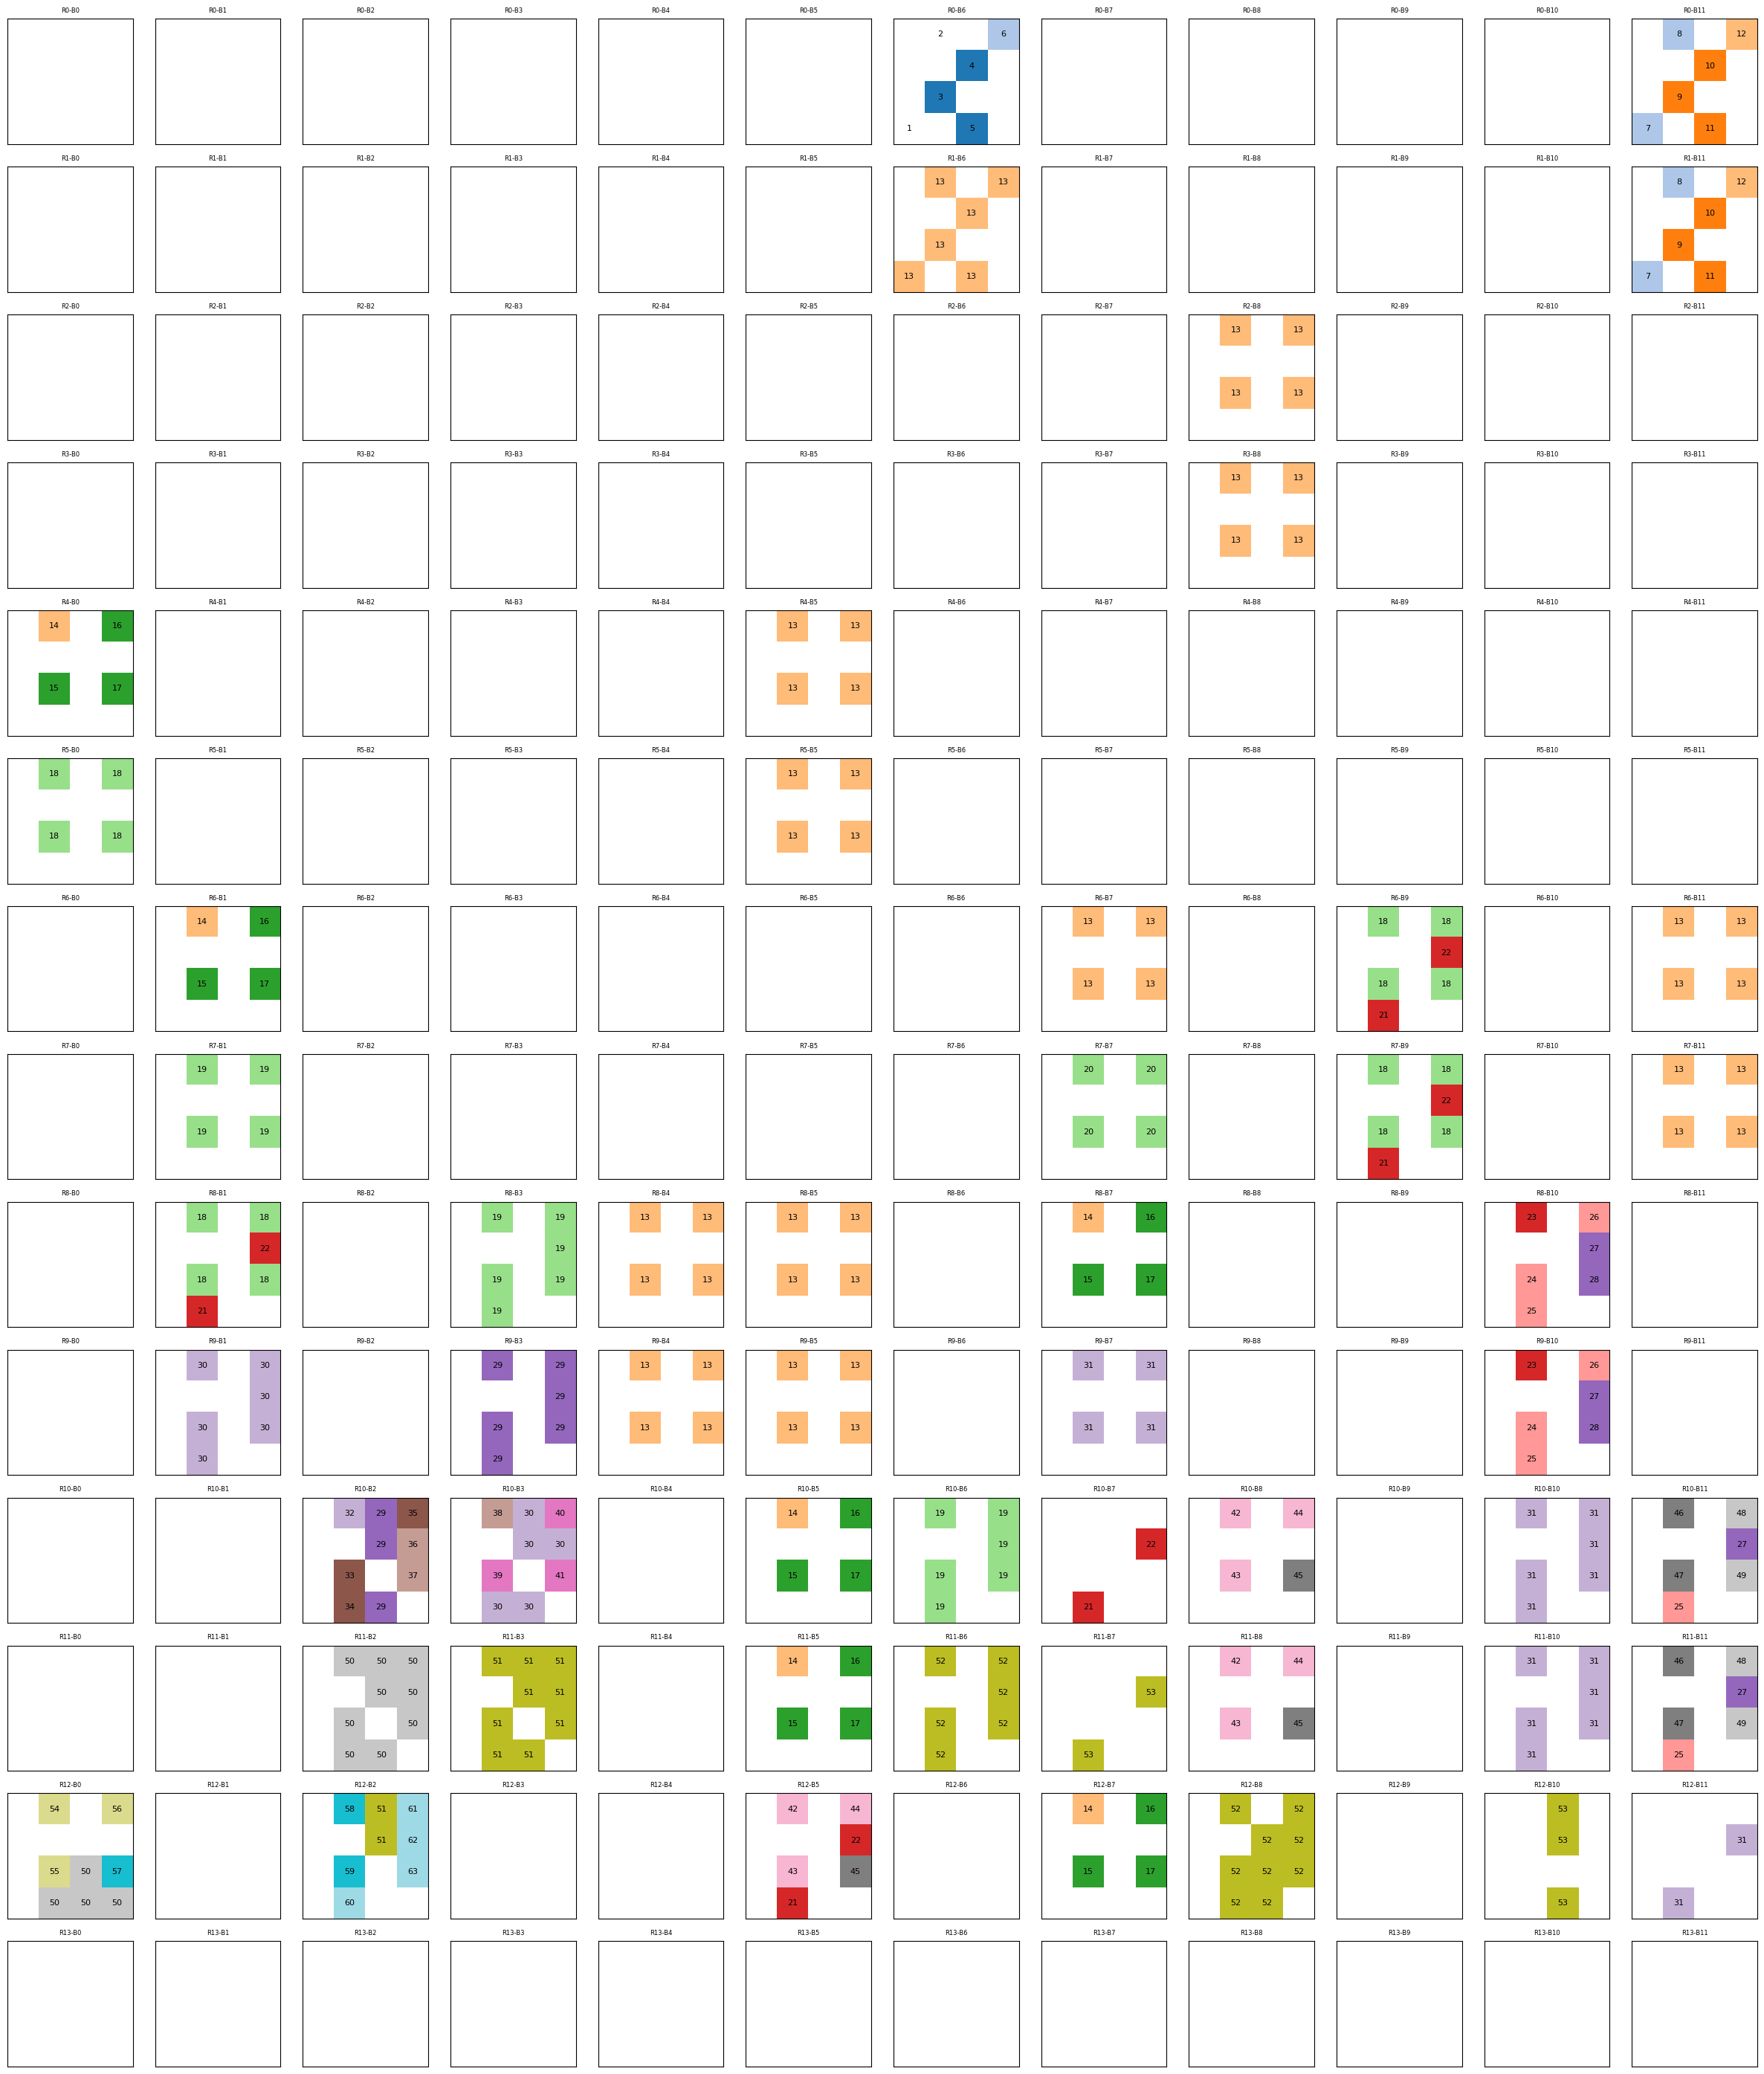

In [86]:
rounds = 7
trait = ActiveGroups(S, rounds, num_blocks=12, block_size=16)
trait.P_rounds(rounds)
groups = trait.get_groups()

# print(groups)
# print(len(groups))
# print("len(group_id) =", len(groups))             # 应该是 14
# print("len(group_id[0]) =", len(groups[0]))       # 应该是 12
# print("len(group_id[0][0]) =", len(groups[0][0])) # 应该是 16

plot_groups(trait.get_groups(), show_numbers=True)


In [58]:
len(solution_array)
solution_array

[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0,